<a href="https://colab.research.google.com/github/varunkamate/YOUTUBE_COMMENT_SENTIMENT_ANALYSIS/blob/main/YOUTUBE_COMMENT_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imported all the required libraries here**

This code installs the OpenAI library, connects to the OpenAI API using your stored API key in Google Colab, and sets up variables for a YouTube video ID and a Google API key that can be used later for fetching or analyzing YouTube data.

In [ ]:
!pip install openai

from openai import OpenAI
from google.colab import userdata

# Instantiate OpenAI client (ensure your OpenAI API key is set in your environment variables or pass directly here).
client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

VIDEOID = '-YlmnPh-6rE'
GOOGLE_APIKEY = userdata.get('YT_APIKEY')

This code fetches the transcript of a YouTube video (in Hindi or English) using the youtube-transcript-api, then sends that transcript to OpenAI’s GPT model to generate a detailed summary, and finally prints the summary.

In [ ]:
!pip install youtube-transcript-api

from youtube_transcript_api import YouTubeTranscriptApi

def get_video_transcript(video_id):
  try:
      # Fetching the transcript
      transcript = YouTubeTranscriptApi.get_transcript(video_id,  languages=['hi', 'en'])

      # Combine all text entries into a single string
      full_transcript = " ".join(entry['text'] for entry in transcript)
      return full_transcript
  except Exception as e:
      print(f"Failed to fetch transcript: {e}")
      return ""

def get_transcript_summary(transcript):
  response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Provide a detailed summary of the given youtube video transcript."},
            {"role": "user", "content": transcript}
        ]
    )
  return response.choices[0].message.content

video_transcript = get_video_transcript(VIDEOID)
transcript_summary = get_transcript_summary(video_transcript)
print(transcript_summary)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.0/485.0 kB 9.5 MB/s eta 0:00:00
Failed to fetch transcript: type object 'YouTubeTranscriptApi' has no attribute 'get_transcript'
I'm sorry, but without the actual content of the video transcript, I am unable to provide a detailed summary. If you can provide me with the transcript, I would be happy to help summarize it for you.


This code uses the YouTube Data API to fetch all top-level comments from a given video. It loops through all pages of comments (up to 100 per request) and stores them in a list, then prints the list of comments.

In [ ]:
from googleapiclient.discovery import build

# Function to get YouTube comments
def get_comments(video_id, api_key):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    response = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        textFormat="plainText",
        maxResults=100
    ).execute()

    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        if 'nextPageToken' in response:
            response = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                pageToken=response['nextPageToken'],
                maxResults=100
            ).execute()
        else:
            break

    return comments

video_comments = get_comments(VIDEOID, GOOGLE_APIKEY)
print(video_comments)

['another Aujla special putting us right in the feels 😭🫶', 'Purana Aujla ❤', "i don't listen to these songs but it have some good vibes", '1. Bro face 2. Bro voice 3. Bro content 4. Bro subscribers 5. Bro energy 6. Bro hustle 7. Bro squad 8. Bro flex 9. Bro vibes 10. Bro attitude 11. Bro style 12. Bro goals 13. Bro skills 14. Bro grind 15. Bro dreams 16. Bro mindset 17. Bro legacy 18. Bro wins 19. Bro journey 20. Bro power 21. Bro focus 22. Bro squadron 23. Bro passion 24. Bro vision 25. Bro respect 26. Bro charisma 27. Bro fame 28. Bro progress 29. Bro hype 30. Bro chill 31. Bro courage 32. Bro wealth 33. Bro team 34. Bro art 35. Bro future 36. Bro innovation 37. Bro strategy 38. Bro drive 39. Bro dedication 40. Bro influence 41. Bro squad goals 42. Bro loyalty 43. Bro adventure 44. Bro story 45. Bro hustle hours 46. Bro network 47. Bro creativity 48. Bro elevation 49. Bro wisdom 50. Bro solutions 51. Bro achievements 52. Bro faith 53. Bro decisions 54. Bro connection 55. Bro skills u

batch_comments

Splits a long list of YouTube comments into smaller batches so that each batch stays under a token limit (default 2048 words) suitable for sending to OpenAI.

get_comments_summaries

Sends each batch of comments to OpenAI’s GPT model to generate a summary while keeping detailed context.

Collects all batch summaries in a list.

create_final_summary

Combines all batch summaries and the video transcript summary.

Sends this combined text to GPT to produce a final, detailed analysis of the comments in the context of the video.

The final summary highlights positives, criticisms, and content suggestions based on the comments relative to the transcript.

In [ ]:
# Function to split comments into manageable batches
def batch_comments(comments, max_tokens=2048):
    batches = []
    current_batch = []
    current_length = 0

    for comment in comments:
        comment_length = len(comment.split())
        if current_length + comment_length > max_tokens:
            batches.append(current_batch)
            current_batch = [comment]
            current_length = comment_length
        else:
            current_batch.append(comment)
            current_length += comment_length

    if current_batch:
        batches.append(current_batch)

    return batches

# Function to get summaries from OpenAI
def get_comments_summaries(batches):
    summaries = []

    for batch in batches:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Summarize the following comments while keeping the detailed context."},
                {"role": "user", "content": " ".join(batch)}
            ]
        )
        print(response)
        summaries.append(response.choices[0].message.content)

    return summaries

# Function to create final summary from summaries
def create_final_summary(summaries, transcript_summary):
    summary_text = " ".join(summaries)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
              {"role": "system", "content": f"This is the summary of a YouTube video's transcript: {transcript_summary}. A user has commented on the video. Your task is to analyze this comment in the context of the video transcript. Based on the comment content and its relation to the transcript, please provide detailed insights, addressing these key points:\n1. Identify positive aspects of the video that the comment highlights and link these to specific parts of the transcript where possible.\n2. Identify any criticisms or areas for improvement mentioned in the comment, and relate these to relevant sections of the transcript.\n3. Based on the feedback or suggestions in the comment, recommend new content ideas or topics for future videos that align with the viewer's interests and the overall content strategy but don't make up things from your side unnecessarily. Ensure your analysis is clear and includes specific examples from both the comment and the transcript to support your insights."},
              {"role": "user", "content": summary_text}
        ]
    )
    return response.choices[0].message.content

batch_comments(video_comments) splits all YouTube comments into smaller batches.

get_comments_summaries(batches) sends each batch to GPT to create summaries of the comments.

create_final_summary(summaries, transcript_summary) combines these comment summaries with the video transcript summary to produce a detailed analysis.

print(final_comments_summary) displays the final, comprehensive insights from the comments in the context of the video.

In [ ]:
batches = batch_comments(video_comments)
summaries = get_comments_summaries(batches)
final_comments_summary = create_final_summary(summaries, transcript_summary)
print(final_comments_summary)

ChatCompletion(id='chatcmpl-CPOUnNml3n0QhE0mqJliedYVmAl7D', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="The comments express admiration for a song by Aujla, highlighting its emotional impact. The song is praised for its vibes, lyrics, and Aujla's talent. Listeners resonate with the Punjabi music healing effect and appreciate the absence of certain clichés in the music video. Some comments mention specific dates like October 11, 2025, as milestones for reaching 100 million views. There's also excitement and anticipation for hitting that milestone, along with reflections on the song's deep emotional impact. A glimpse of the translated lyrics reveals their beauty, and the viewers appreciate the song's ability to evoke feelings. There are also playful comments about personal connections to the song and lighthearted jesting regarding various aspects of the video and its impact.", refusal=None, role='assistant', annotations=[], audio=N

This function analyzes each YouTube comment for sentiment using a sentiment_analyzer, then counts how many are positive, negative, or neutral. Comments with a high-confidence positive or negative score (>0.9) are classified accordingly; all others are counted as neutral.

In [ ]:
def get_sentiments(comments):
    sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}

    for comment in comments:
        # Perform sentiment analysis on each comment individually
        try:
            sentiments = sentiment_analyzer(comment)
            # Assuming the first result is the relevant one if multiple are returned
            sentiment = sentiments[0] if isinstance(sentiments, list) and sentiments else None
        except Exception as e:
            print(f"Error in sentiment analysis: {e}")
            sentiment = None

        # Tally sentiments based on the analysis result
        if sentiment and sentiment['label'] == 'POSITIVE' and sentiment['score'] > 0.9:
            sentiment_counts['positive'] += 1
        elif sentiment and sentiment['label'] == 'NEGATIVE' and sentiment['score'] > 0.9:
            sentiment_counts['negative'] += 1
        else:
            sentiment_counts['neutral'] += 1

    return sentiment_counts

This function takes the counts of positive, negative, and neutral comments and plots a pie chart showing the sentiment distribution, with the positive slice slightly highlighted.

In [ ]:
# Function to plot the sentiment distribution
def plot_sentiment_distribution(sentiment_counts):
    labels = sentiment_counts.keys()
    sizes = sentiment_counts.values()
    colors = ['gold', 'lightcoral', 'lightskyblue']
    explode = (0.1, 0, 0)  # explode 1st slice

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

This code installs the transformers and matplotlib libraries, sets up a sentiment analysis pipeline using Hugging Face Transformers, analyzes all YouTube comments to count positive, negative, and neutral sentiments, and then plots these results as a pie chart.

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (1371 > 512). Running this sequence through the model will result in indexing errors


Error in sentiment analysis: The size of tensor a (1371) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (669) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (1372) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (881) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (2508) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (1372) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (1344) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Error in se

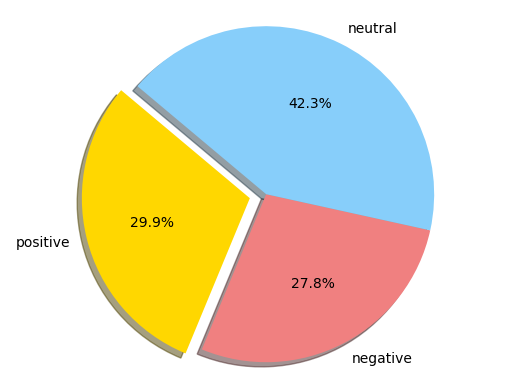

In [ ]:
!pip install transformers matplotlib

import matplotlib.pyplot as plt
from transformers import pipeline

# Initialize the sentiment-analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

sentiment_counts = get_sentiments(video_comments)
plot_sentiment_distribution(sentiment_counts)